In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Purpose of this notebook

This notebook serves to demonstrate a run-down for the process of creating a disparity map using two seperate pictures captured by a stereo camera, and then generating a 3D point cloud out of that disparity map.

Use OpenCV to load the two test images

In [2]:
image1 = cv2.imread('../test/testdata/image1.png', 0)

In [3]:
image1.shape

(375, 1242)

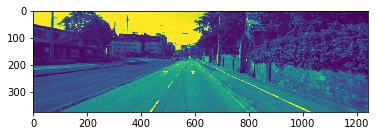

In [4]:
plt.imshow(image1)

In [5]:
image2 = cv2.imread('../test/testdata/image2.png', 0)

In [6]:
image2.shape

(375, 1242)

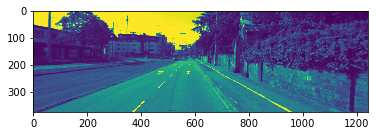

In [7]:
plt.imshow(image2)

Create the disparity map of the two images

In [8]:
stereo = cv2.StereoBM_create(numDisparities = 96, blockSize = 11)
disparity = stereo.compute(image1, image2)

In [9]:
disparity_result = disparity.copy()

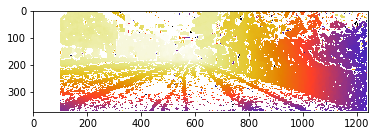

In [10]:
plt.imshow(disparity_result, 'CMRmap_r')

Read in calibration

In [11]:
matrix_type_1 = 'P2'
matrix_type_2 = 'P3'

calib_file = '../calib/calibration_data.txt'
with open(calib_file, 'r') as f:
    fin = f.readlines()
    for line in fin:
        if line[:2] == matrix_type_1:
            calib_matrix_1 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)
        elif line[:2] == matrix_type_2:
            calib_matrix_2 = np.array(line[4:].strip().split(" ")).astype('float32').reshape(3,-1)

Calculate depth-to-disparity

In [12]:
image1_colored = cv2.imread('../test/testdata/image1.png', 1)

In [13]:
cam1 = calib_matrix_1[:,:3] # left image - P2
cam2 = calib_matrix_2[:,:3] # right image - P3

Tmat = np.array([0.54, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = cam1,cameraMatrix2 = cam2, \
                  distCoeffs1 = 0, distCoeffs2 = 0, \
                  imageSize = image1_colored.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);

Output the result 3D Point Cloud

In [14]:
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [15]:
points = cv2.reprojectImageTo3D(disparity_result, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(image1_colored, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = disparity_result > disparity_result.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
idx = np.fabs(out_points[:,0]) < 4.5
out_points = out_points[idx]
out_colors = out_colors.reshape(-1, 3)
out_colors = out_colors[idx]

write_ply('../results/sample_3d_pointcloud.ply', out_points, out_colors)
print('%s saved' % 'sample_3d_pointcloud.ply')

C:\Users\kmcex\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in matmul
  


sample_3d_pointcloud.ply saved


Convert the 3D Point Cloud back into a 2D image

In [16]:
reflected_pts = np.matmul(out_points, reflect_matrix)
projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                          cam2[:3,:3], np.array([0., 0., 0., 0.]))
projected_img = projected_img.reshape(-1, 2)

In [17]:
image2_colored = cv2.imread('../test/testdata/image2.png', 1)

In [18]:
image_3d_to_2d = np.zeros(image1_colored.shape, 'uint8')
img_colors = image2_colored[mask][idx].reshape(-1, 3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0])
    pt_y = int(pt[1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        cv2.circle(image_3d_to_2d, (pt_x, pt_y), 1, col)

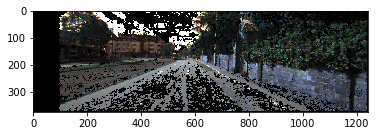

In [19]:
plt.imshow(cv2.cvtColor(image_3d_to_2d, cv2.COLOR_RGB2BGR))